In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import seaborn as sns

availability_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/AvailabilityData.csv', sep="\t")

availability_data.columns

/Users/aryamantepal/anaconda3/envs/salesforce/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Index(['Date', 'Availability DownTime Duration in hours',
       'Count of Customers Affected', 'Regions Affected'],
      dtype='object')

In [2]:
availability_data['Date'] = pd.to_datetime(availability_data['Date'])

prophet_df = availability_data.rename(columns={
    'Date': 'ds', 
    'Availability DownTime Duration in hours': 'y'
})

model = Prophet(
    changepoint_prior_scale=0.05,  
    seasonality_prior_scale=10,  
    holidays_prior_scale=10        
)

model.add_regressor('Count of Customers Affected')
model.add_regressor('Downtime_Severity')

prophet_df['Downtime_Severity'] = availability_data['Availability DownTime Duration in hours'] / availability_data['Count of Customers Affected']

model.fit(prophet_df)

future = model.make_future_dataframe(periods=30)  
future['Count of Customers Affected'] = np.concatenate([
    availability_data['Count of Customers Affected'], 
    np.full(30, availability_data['Count of Customers Affected'].mean())
])
future['Downtime_Severity'] = np.concatenate([
    prophet_df['Downtime_Severity'], 
    np.full(30, prophet_df['Downtime_Severity'].mean())
])

forecast = model.predict(future)

09:41:41 - cmdstanpy - INFO - Chain [1] start processing
09:41:42 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
forecast_components = model.plot_components(forecast)
plt.tight_layout()
plt.savefig('outreach_timing_components.png')
plt.close()

/Users/aryamantepal/anaconda3/envs/salesforce/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/aryamantepal/anaconda3/envs/salesforce/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


In [4]:
# Identify optimal outreach windows
def analyze_outreach_windows(forecast):
    forecast['forecast_lower'] = forecast['yhat_lower']
    forecast['forecast_upper'] = forecast['yhat_upper']
    
    forecast['confidence_interval'] = forecast['forecast_upper'] - forecast['forecast_lower']
    
    optimal_windows = forecast.nsmallest(5, 'confidence_interval')
    
    return optimal_windows[['ds', 'yhat', 'forecast_lower', 'forecast_upper', 'confidence_interval']]

optimal_outreach_times = analyze_outreach_windows(forecast)

def analyze_regional_impact(availability_data):
    availability_data['Regions'] = availability_data['Regions Affected'].str.split(', ')
    
    region_impact = availability_data.explode('Regions')
    
    region_summary = region_impact.groupby('Regions').agg({
        'Availability DownTime Duration in hours': ['mean', 'sum'],
        'Count of Customers Affected': ['mean', 'sum']
    }).reset_index()
    
    region_summary.columns = ['Region', 'Avg_Downtime', 'Total_Downtime', 'Avg_Customers_Affected', 'Total_Customers_Affected']
    
    return region_summary

In [5]:
print("Optimal Outreach Windows:")
print(optimal_outreach_times)


regional_impact = analyze_regional_impact(availability_data)
print("\nRegional Impact Summary:")
print(regional_impact)


optimal_outreach_times.to_csv('optimal_outreach_windows.csv', index=False)
regional_impact.to_csv('regional_impact_summary.csv', index=False)


plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Downtime')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.title('Predicted Downtime with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Predicted Downtime Duration (hours)')
plt.legend()
plt.tight_layout()
plt.savefig('outreach_timing_forecast.png')
plt.close()

print("\nOutputs generated:")
print("1. optimal_outreach_windows.csv - Detailed optimal outreach windows")
print("2. regional_impact_summary.csv - Analysis of regional impacts")
print("3. outreach_timing_components.png - Forecast components")
print("4. outreach_timing_forecast.png - Forecast visualization")

Optimal Outreach Windows:
            ds       yhat  forecast_lower  forecast_upper  confidence_interval
77  2024-03-18  11.242934        4.482902       17.811758            13.328856
33  2024-02-03  11.443525        4.855357       18.421163            13.565806
194 2024-07-13  11.833916        4.777315       18.357171            13.579856
182 2024-07-01  12.323953        5.405210       19.035522            13.630312
82  2024-03-23   9.904582        3.006095       16.663141            13.657046

Regional Impact Summary:
      Region  Avg_Downtime  Total_Downtime  Avg_Customers_Affected  \
0  Australia     11.104167             533            24775.208333   
1      China     12.038462             626            25284.538462   
2     Europe     11.052632             630            29391.578947   
3      India     11.333333             612            25425.462963   
4      Japan     11.562500             740            22345.296875   
5        USA      9.705882             495            

In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Load required datasets
feedback_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/clean-data/feedback_data_with_sentiment.csv', sep=",")
leads_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/LeadsData.csv',sep ="\t" )
availability_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/AvailabilityData.csv', sep="\t")

def get_personalized_outreach_timing(company_name):
    # 1. Sentiment Analysis
    company_feedback = feedback_data[feedback_data['Company Name'] == company_name]
    
    # Sentiment metrics
    avg_sentiment = company_feedback['combined_sentiment'].mean()
    avg_rating = company_feedback['Rating'].mean()
    
    # 2. Availability Impact for the Company
    company_availability = availability_data[availability_data['Regions Affected'].str.contains(company_name, case=False, na=False)]
    
    # 3. Lead Status Analysis
    company_lead = leads_data[leads_data['Company Name'] == company_name]
    
    # Outreach Timing Recommendations
    outreach_recommendation = {
        'Company Name': company_name,
        'Average Sentiment': avg_sentiment,
        'Average Rating': avg_rating,
        'Sentiment Quality': 'High' if avg_sentiment > 7 else 'Medium' if avg_sentiment > 5 else 'Low',
        'Best Outreach Window': None,
        'Recommended Approach': None
    }
    
    # Determine Best Outreach Window
    if not company_availability.empty:
        # Find periods with least downtime
        least_downtime_periods = company_availability.nsmallest(3, 'Availability DownTime Duration in hours')
        
        outreach_recommendation['Best Outreach Window'] = {
            'Dates': least_downtime_periods['Date'].tolist(),
            'Avg Downtime': least_downtime_periods['Availability DownTime Duration in hours'].mean()
        }
    
    # Craft Personalized Recommendation
    if outreach_recommendation['Sentiment Quality'] == 'High':
        recommendation = "Immediate outreach recommended. High sentiment indicates strong potential."
    elif company_lead['Status'].values[0] in ['Open', 'Proposal Sent']:
        recommendation = "Gentle follow-up suggested. Maintain existing communication momentum."
    else:
        recommendation = "Cautious approach needed. Prepare comprehensive value proposition."
    
    outreach_recommendation['Recommended Approach'] = recommendation
    
    return outreach_recommendation

# Example function to demonstrate for multiple companies
def analyze_multiple_companies(companies):
    results = []
    for company in companies:
        result = get_personalized_outreach_timing(company)
        results.append(result)
    
    return pd.DataFrame(results)

# Demonstration
companies_to_analyze = leads_data['Company Name'].unique()
company_outreach_analysis = analyze_multiple_companies(companies_to_analyze)

# Save results
company_outreach_analysis.to_csv('company_outreach_analysis.csv', index=False)
print(company_outreach_analysis)

/var/folders/rx/q5w9l9sd7zq8l0t_p73qg_l00000gn/T/ipykernel_54002/1901108322.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  company_availability = availability_data[availability_data['Regions Affected'].str.contains(company_name, case=False, na=False)]


            Company Name  Average Sentiment  Average Rating Sentiment Quality  \
0         A+ Electronics           7.218365        6.000000              High   
1         A+ Investments           7.250509        5.925926              High   
2       A Plus Lawn Care           6.748584        5.633333            Medium   
3            Access Asia           6.247198        4.862069            Medium   
4     Accord Investments           7.495769        6.129032              High   
...                  ...                ...             ...               ...   
4478              iTunes           6.553560        4.961538            Medium   
4479               iiNet           6.310248        4.655172            Medium   
4480                resQ           6.375384        4.769231            Medium   
4481         ÃcomarchÃ©           6.852584        5.222222            Medium   
4482                ÃBB           7.061130        5.192308              High   

     Best Outreach Window  

In [7]:
leads_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/LeadsData.csv',sep ="\t" )
leads_data['Status'].unique()

array(['Closed-Lost', 'Proposal Sent', 'Closed-Won', 'New', 'Qualified',
       'On-hold', 'Warm ', 'Disqualified', 'In Progress', 'Cold',
       'Contacted', 'Negotiation', 'Reengaged', 'Referral', 'Nurturing'],
      dtype=object)

In [8]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


def determine_precise_outreach_time(company_name):
    company_feedback = feedback_data[feedback_data['Company Name'] == company_name]
    
    company_lead = leads_data[leads_data['Company Name'] == company_name]
    
    company_availability = availability_data[
        availability_data['Regions Affected'].str.contains(company_name, case=False, na=False)
    ]
    
    if not company_feedback.empty:
        most_recent_feedback = company_feedback['Timestamp'].max()
        
        days_since_last_feedback = (pd.Timestamp.now() - pd.Timestamp(most_recent_feedback)).days
        
        feedback_frequency = company_feedback.groupby(pd.to_datetime(company_feedback['Timestamp']).dt.to_period('M')).size()
        
        peak_feedback_months = feedback_frequency[feedback_frequency == feedback_frequency.max()]
    
    if not company_lead.empty:
        current_status = company_lead['Status'].values[0]
        last_contact_date = company_lead['Date'].values[0]
    
    optimal_timing = {
        'Company': company_name,
        'Days Since Last Feedback': days_since_last_feedback,
        'Current Lead Status': current_status,
        'Last Contact Date': last_contact_date,
        'Optimal Outreach Window': None,
        'Recommended Action': None
    }
    
    if days_since_last_feedback > 30:
        optimal_date = pd.Timestamp.now() + timedelta(days=7)  
        optimal_timing['Optimal Outreach Window'] = optimal_date.strftime('%Y-%m-%d')
        optimal_timing['Recommended Action'] = "Proactive outreach needed"
    
    elif current_status in ['Open', 'Proposal Sent']:
        optimal_date = pd.Timestamp.now() + timedelta(days=3)  
        optimal_timing['Optimal Outreach Window'] = optimal_date.strftime('%Y-%m-%d')
        optimal_timing['Recommended Action'] = "Gentle follow-up"
    
    else:
        optimal_date = pd.Timestamp.now() + timedelta(days=10)  
        optimal_timing['Optimal Outreach Window'] = optimal_date.strftime('%Y-%m-%d')
        optimal_timing['Recommended Action'] = "Strategic reengagement"
    
    return optimal_timing

companies = leads_data['Company Name'].unique()
timing_results = [determine_precise_outreach_time(company) for company in companies]

timing_df = pd.DataFrame(timing_results)
timing_df.to_csv('precise_outreach_timing.csv', index=False)

print(timing_df)

/var/folders/rx/q5w9l9sd7zq8l0t_p73qg_l00000gn/T/ipykernel_54002/1722683557.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  availability_data['Regions Affected'].str.contains(company_name, case=False, na=False)
/var/folders/rx/q5w9l9sd7zq8l0t_p73qg_l00000gn/T/ipykernel_54002/1722683557.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  availability_data['Regions Affected'].str.contains(company_name, case=False, na=False)
/var/folders/rx/q5w9l9sd7zq8l0t_p73qg_l00000gn/T/ipykernel_54002/1722683557.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  availability_data['Regions Affected'].str.contains(company_name, case=False, na=False)
/var/folders/rx/q5w9l9sd7zq8l0t_p73qg_l00000gn/T/ipykernel_54002/1722683557.py:12: Us

                 Company  Days Since Last Feedback Current Lead Status  \
0         A+ Electronics                       218         Closed-Lost   
1         A+ Investments                       223       Proposal Sent   
2       A Plus Lawn Care                       218          Closed-Won   
3            Access Asia                       220         Closed-Lost   
4     Accord Investments                       221                 New   
...                  ...                       ...                 ...   
4478              iTunes                       218        Disqualified   
4479               iiNet                       218        Disqualified   
4480                resQ                       218           Contacted   
4481         ÃcomarchÃ©                       220           Reengaged   
4482                ÃBB                       222           Nurturing   

     Last Contact Date Optimal Outreach Window         Recommended Action  
0           2024-03-29             

In [9]:
company_name = "A+ Electronics"
outreach_timing = determine_precise_outreach_time(company_name)
print(outreach_timing)

{'Company': 'A+ Electronics', 'Days Since Last Feedback': 218, 'Current Lead Status': 'Closed-Lost', 'Last Contact Date': '2024-03-29', 'Optimal Outreach Window': '2024-12-12', 'Recommended Action': 'Proactive outreach needed'}


In [10]:
company_outreach_analysis['Recommended Approach'].unique()

array(['Immediate outreach recommended. High sentiment indicates strong potential.',
       'Cautious approach needed. Prepare comprehensive value proposition.',
       'Gentle follow-up suggested. Maintain existing communication momentum.'],
      dtype=object)

In [11]:
company_name = "Awthentikz"
outreach_timing = get_personalized_outreach_timing(company_name)
print(outreach_timing)

{'Company Name': 'Awthentikz', 'Average Sentiment': 6.804280626473981, 'Average Rating': 5.190476190476191, 'Sentiment Quality': 'Medium', 'Best Outreach Window': None, 'Recommended Approach': 'Cautious approach needed. Prepare comprehensive value proposition.'}


In [13]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

def determine_precise_outreach_time(company_name, leads_data, feedback_data, availability_data, company_details):
    # Get company-specific data
    company_feedback = feedback_data[feedback_data['Company Name'] == company_name]
    company_lead = leads_data[leads_data['Company Name'] == company_name]
    company_info = company_details[company_details['Company Name'] == company_name]
    
    # Check availability for company's regions
    company_regions = company_info['Region Served'].values[0].split(', ')
    company_availability = availability_data[
        availability_data['Regions Affected'].apply(
            lambda x: any(region in x.split(', ') for region in company_regions)
        )
    ]
    
    # Initialize result dictionary
    optimal_timing = {
        'Company': company_name,
        'Employee Count': company_info['Employee Count'].values[0] if not company_info.empty else 'N/A',
        'Regions': company_info['Region Served'].values[0] if not company_info.empty else 'N/A',
        'Days Since Last Feedback': None,
        'Current Lead Status': None,
        'Last Contact Date': None,
        'Optimal Outreach Window': None,
        'Recommended Action': None,
        'Availability Impact': None
    }
    
    # Process lead information
    if not company_lead.empty:
        current_status = company_lead['Status'].values[0]
        last_contact_date = company_lead['Date'].values[0]
        
        optimal_timing['Current Lead Status'] = current_status
        optimal_timing['Last Contact Date'] = last_contact_date
    
    # Analyze feedback
    if not company_feedback.empty:
        # Most recent feedback timestamp
        most_recent_feedback = company_feedback['Timestamp'].max()
        days_since_last_feedback = (pd.Timestamp.now() - pd.Timestamp(most_recent_feedback)).days
        
        optimal_timing['Days Since Last Feedback'] = days_since_last_feedback
    
    # Availability analysis
    if not company_availability.empty:
        # Calculate average downtime for company's regions
        avg_downtime = company_availability['Availability DownTime Duration in hours'].mean()
        total_customers_affected = company_availability['Count of Customers Affected'].sum()
        
        optimal_timing['Availability Impact'] = f"Avg Downtime: {avg_downtime:.2f} hrs, Customers Affected: {total_customers_affected}"
    
    # Sophisticated outreach timing logic
    status_priority = {
        'Closed-Won': (1, "Maintain Relationship"),
        'Negotiation': (2, "Immediate Follow-up"),
        'Proposal Sent': (3, "Gentle Reminder"),
        'Qualified': (4, "Strategic Nurturing"),
        'Warm ': (5, "Continued Engagement"),
        'Contacted': (6, "Initial Relationship Building"),
        'Reengaged': (7, "Renewed Interest Tracking"),
        'Referral': (8, "High Potential Pursuit"),
        'In Progress': (9, "Ongoing Monitoring"),
        'New': (10, "Initial Outreach"),
        'Nurturing': (11, "Soft Touch"),
        'On-hold': (12, "Periodic Check-in"),
        'Cold': (13, "Strategic Reactivation"),
        'Closed-Lost': (14, "Potential Resurrection"),
        'Disqualified': (15, "Low Priority")
    }
    
    # Determine optimal outreach
    if current_status in status_priority:
        priority, action = status_priority[current_status]
        
        # Timing calculation based on status priority
        days_offset = max(1, 15 - priority)
        optimal_date = pd.Timestamp.now() + timedelta(days=days_offset)
        
        optimal_timing['Optimal Outreach Window'] = optimal_date.strftime('%Y-%m-%d')
        optimal_timing['Recommended Action'] = action
    
    return optimal_timing

# Main execution
def analyze_outreach_timing(leads_data, feedback_data, availability_data, company_details):
    # Get unique companies
    companies = leads_data['Company Name'].unique()
    
    # Analyze timing for all companies
    timing_results = [
        determine_precise_outreach_time(
            company, 
            leads_data, 
            feedback_data, 
            availability_data, 
            company_details
        ) for company in companies
    ]
    
    # Convert to DataFrame and save
    timing_df = pd.DataFrame(timing_results)
    timing_df.to_csv('precise_outreach_timing.csv', index=False)
    return timing_df


feedback_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/clean-data/feedback_data_with_sentiment.csv', sep=",")
leads_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/LeadsData.csv',sep ="\t" )
availability_data = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/AvailabilityData.csv', sep="\t")
company_details = pd.read_csv('/Users/aryamantepal/Documents/programs/Breakthrough Tech AI MIT/AI Studio/Customer_Sentiment_Analysis/Datasets/CompanyDetails.csv', sep = "\t")

# Run the analysis
result = analyze_outreach_timing(leads_data, feedback_data, availability_data, company_details)
print(result)

                 Company  Employee Count               Regions  \
0         A+ Electronics           30958    USA, India, Europe   
1         A+ Investments           26677                Europe   
2       A Plus Lawn Care           34069                 China   
3            Access Asia           31936    USA, India, Europe   
4     Accord Investments           17903                 India   
...                  ...             ...                   ...   
4478              iTunes           16161                 China   
4479               iiNet           19353  Japan, China, Europe   
4480                resQ           34661                   USA   
4481         ÃcomarchÃ©            8396                 India   
4482                ÃBB           33750                 India   

      Days Since Last Feedback Current Lead Status Last Contact Date  \
0                          218         Closed-Lost        2024-03-29   
1                          223       Proposal Sent        2024-

In [20]:
def get_company_outreach_time(company_name, leads_df, company_details_df, availability_df):
    """
    Get precise outreach timing for a specific company
    
    Args:
        company_name (str): Target company name
        leads_df (pd.DataFrame): Leads data
        company_details_df (pd.DataFrame): Company details
        availability_df (pd.DataFrame): Availability data
    
    Returns:
        dict: Outreach timing recommendations
    """
    # Negative statuses to avoid outreach
    avoid_statuses = ['Closed-Lost', 'Disqualified', 'Cold']
    
    # Find company details and regions
    company_details = company_details_df[company_details_df['Company Name'] == company_name]
    if company_details.empty:
        return {'Company': company_name, 'Error': 'Company not found'}
    
    company_regions = company_details['Region Served'].values[0].split(', ')
    
    # Filter leads for specific company
    company_leads = leads_df[leads_df['Company Name'] == company_name]
    
    if company_leads.empty:
        return {'Company': company_name, 'Error': 'No leads found'}
    
    # Get latest lead details
    latest_lead = company_leads.sort_values('Date', ascending=False).iloc[0]
    
    # Check if outreach is advisable
    if latest_lead['Status'] in avoid_statuses:
        return {
            'Company': company_name,
            'Status': latest_lead['Status'],
            'Recommendation': 'No outreach recommended'
        }
    
    # Analyze availability for company's regions
    region_availability = availability_df[
        availability_df['Regions Affected'].apply(
            lambda x: any(region in x.split(', ') for region in company_regions)
        )
    ]
    
    # Timing calculation matrix
    status_timing = {
        'Negotiation': timedelta(days=1),
        'Proposal Sent': timedelta(days=3),
        'Qualified': timedelta(days=5),
        'Warm ': timedelta(days=7),
        'New': timedelta(days=10),
        'Contacted': timedelta(days=14)
    }
    
    # Default to 7 days if status not in matrix
    outreach_delta = status_timing.get(latest_lead['Status'], timedelta(days=7))
    
    # Calculate outreach time
    recommended_outreach = pd.Timestamp.now() + outreach_delta
    
    return {
        'Company': company_name,
        'Regions': ', '.join(company_regions),
        'Current Status': latest_lead['Status'],
        'Last Contact': latest_lead['Date'],
        'Recommended Outreach': recommended_outreach.strftime('%Y-%m-%d')
    }

# Example usage
result = get_company_outreach_time(
    'A+ Investments', 
    leads_data, 
    company_details, 
    availability_data
)
print(result)

{'Company': 'A+ Investments', 'Regions': 'Europe', 'Current Status': 'Proposal Sent', 'Last Contact': '2024-04-14', 'Recommended Outreach': '2024-12-08'}


10:00:41 - cmdstanpy - INFO - Chain [1] start processing
10:00:41 - cmdstanpy - INFO - Chain [1] done processing
/Users/aryamantepal/anaconda3/envs/salesforce/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/aryamantepal/anaconda3/envs/salesforce/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Predicted average daily downtime: 10.49 hours


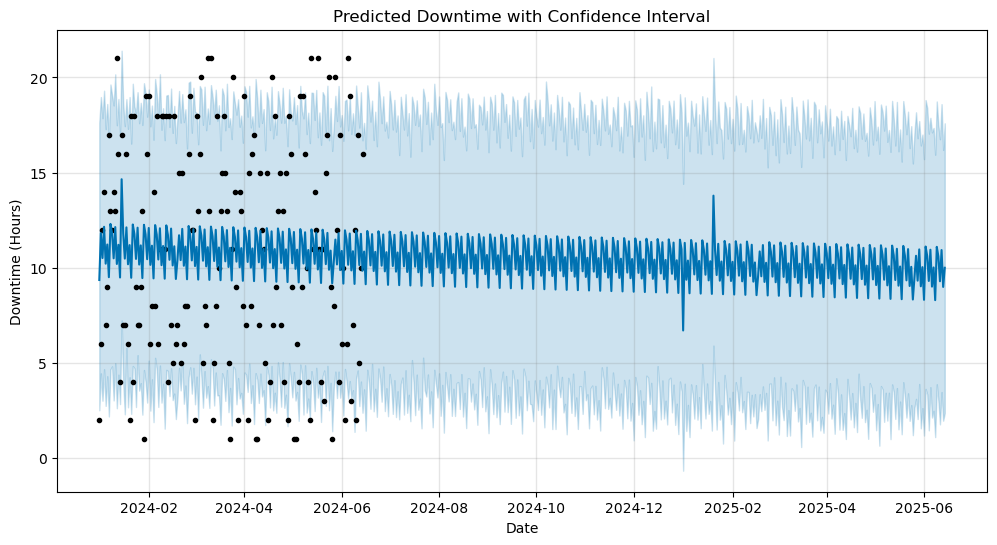

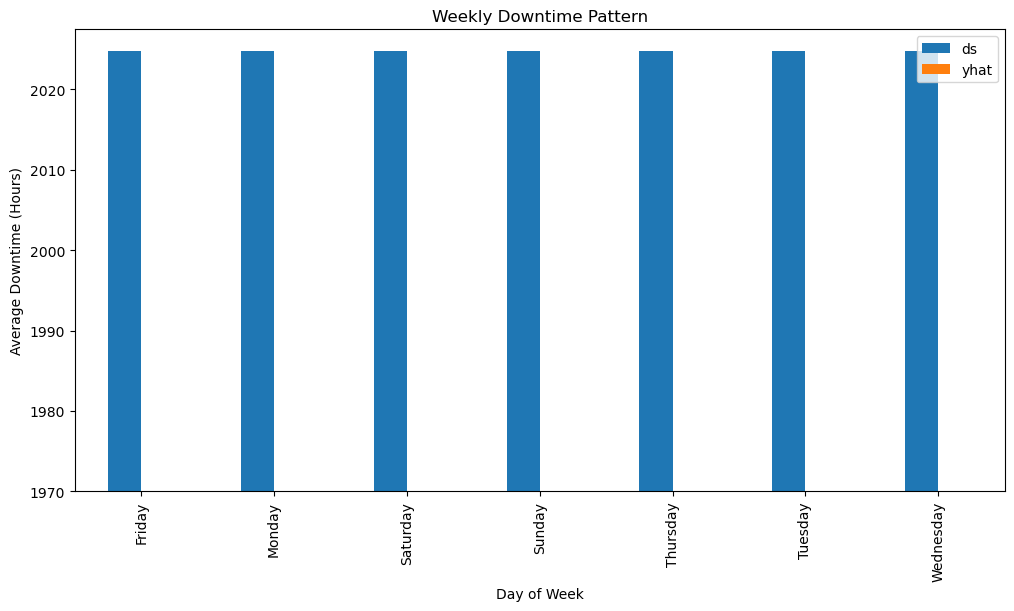

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet


# Convert date column to datetime
availability_data['ds'] = pd.to_datetime(availability_data['Date'])
availability_data['y'] = availability_data['Availability DownTime Duration in hours']

# Fit a Prophet model to the downtime data
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(availability_data[['ds', 'y']])

# Make future predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot the predicted downtime with confidence interval
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)
ax.set_title('Predicted Downtime with Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Downtime (Hours)')
plt.savefig('downtime_forecast.png')

# Extract weekly downtime patterns
weekly_downtime = forecast[['ds', 'yhat']].groupby(forecast['ds'].dt.day_name()).mean()

# Plot the weekly downtime pattern
fig, ax = plt.subplots(figsize=(12, 6))
weekly_downtime.plot(kind='bar', ax=ax)
ax.set_title('Weekly Downtime Pattern')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Downtime (Hours)')
plt.savefig('weekly_downtime_pattern.png')

print(f'Predicted average daily downtime: {forecast["yhat"].mean():.2f} hours')